## Sunset Park flight trajectory

### Data preparation

Get the data from the SDR or set the file paths in the next code block.

In [1]:
TMP_DIR = 'tmp'

!mkdir -p $TMP_DIR
!grep "\<.*doc.zip.*\>" ../data/metadata/sp19-bitstreams.json | tr -d ',' | xargs wget -nd --no-check-certificate -P $TMP_DIR
!unzip $TMP_DIR/*.zip -d $TMP_DIR

!mv "$TMP_DIR/flight-trajectory-shps/mission2/export_Mission 1.txt" ../data/misc/lift1.txt
!mv "$TMP_DIR/flight-trajectory-shps/mission2/export_Mission 1.kml" ../data/misc/lift1.kml
!mv "$TMP_DIR/flight-trajectory-shps/mission3/export_Mission 1.txt" ../data/misc/lift2.txt
!mv "$TMP_DIR/flight-trajectory-shps/mission3/export_Mission 1.kml" ../data/misc/lift2.kml

!rm -rf $TMP_DIR

--2020-08-02 15:38:32--  https://archive.nyu.edu/bitstream/2451/60458/1/nyu_2451_60458_doc.zip
Resolving archive.nyu.edu (archive.nyu.edu)... 128.122.108.142
Connecting to archive.nyu.edu (archive.nyu.edu)|128.122.108.142|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 417537009 (398M) [application/octet-stream]
Saving to: ‘tmp/nyu_2451_60458_doc.zip’

nyu_2451_60458_doc. 100%[===================>] 398.19M  11.8MB/s    in 37s     

2020-08-02 15:39:10 (10.7 MB/s) - ‘tmp/nyu_2451_60458_doc.zip’ saved [417537009/417537009]

Archive:  tmp/nyu_2451_60458_doc.zip
   creating: tmp/flight-trajectory-shps/
  inflating: tmp/__MACOSX/._flight-trajectory-shps  
  inflating: tmp/flight-trajectory-shps/.DS_Store  
  inflating: tmp/__MACOSX/flight-trajectory-shps/._.DS_Store  
   creating: tmp/flight-trajectory-shps/mission3/
  inflating: tmp/__MACOSX/flight-trajectory-shps/._mission3  
   creating: tmp/flight-trajectory-sh

Set the file paths

In [2]:
lift1_fpath = '../data/misc/lift1.txt'
lift2_fpath = '../data/misc/lift2.txt'

!ls $lift1_fpath
!ls $lift2_fpath

../data/misc/lift1.txt
../data/misc/lift2.txt


Some metadata in the file header

In [3]:
!head -27 $lift1_fpath

### Parsing

In [4]:
import numpy as np
import pandas as pd

def parse_lift(path):
    return pd.read_csv(path, 
             skiprows = 27, 
             sep = '\s+',
             #nrows = 1000,
             #chunksize=1000,
             names = ['time', 'distance', 
                     'easting', 'northing', 'ellipsoid_height', 
                     'latitude', 'longitude', 'ellipsoid_height_2', 
                     'roll', 'pitch', 'heading', 
                     'east_velocity', 'north_velocity', 'up_velocity', 
                     'east_sd', 'north_sd', 'height_sd', 'roll_sd', 'pitch_sd', 'heading_sd' ]
            )

lift1 = parse_lift(lift1_fpath)
lift2 = parse_lift(lift2_fpath)

flight = pd.concat([lift1, lift2], ignore_index = True)

print('{:,} records parsed\n[{:,} from lift #1 and {:,} from lift #2]'.format(len(flight), len(lift1), len(lift2)))

2,553,171 records parsed
[1,739,181 from lift #1 and 813,990 from lift #2]


### Plot configurations

In [5]:
from datetime import datetime

import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits

converter = mdates.ConciseDateConverter()
#munits.registry[np.datetime64] = converter
#munits.registry[datetime.date] = converter
munits.registry[datetime] = converter

locator = mdates.AutoDateLocator(minticks=3, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Temporal extent

In [6]:
from als.base import GPSTimeUtil
timeutil = GPSTimeUtil(flight_date = datetime(2019, 5, 11))

time = flight['time']
time_lift1 = lift1['time']
time_lift2 = lift2['time']

temporal_extent = pd.DataFrame(columns=['lift1', 'lift2', 'flight'], index = ['tmin', 'tmax'])
temporal_extent['lift1'] = [min(time_lift1), max(time_lift1)]
temporal_extent['lift2'] = [min(time_lift2), max(time_lift2)]
temporal_extent['flight'] = [min(time), max(time)]
temporal_extent

,lift1,lift2,flight
tmin,576186.00101,588578.00495,576186.00101
tmax,584882.00452,592648.00001,592648.00001


In [7]:
prev_sunday = timeutil.previous_sunday()
f = lambda _ : timeutil.gpstime_to_datetime(_, prev_sunday)
temporal_extent.applymap(f)

,lift1,lift2,flight
tmin,2019-05-11 16:03:06.001010,2019-05-11 19:29:38.004950,2019-05-11 16:03:06.001010
tmax,2019-05-11 18:28:02.004520,2019-05-11 20:37:28.000010,2019-05-11 20:37:28.000010


Text(2019-05-11 20:11:53.002278, 590613.0022775284, 'Lift #2')

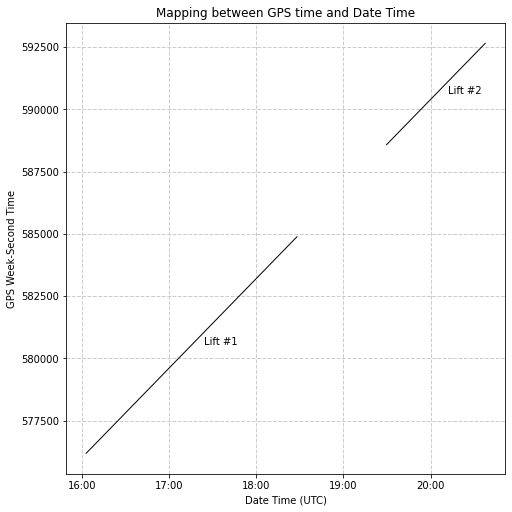

In [8]:
from datetime import timedelta

plt.rc('figure', figsize=(7, 7))

fig, ax = plt.subplots(1, 1, 
                         #sharey=True,
                         #sharex = 'col'
                         constrained_layout=True
                        )

ax.grid(linestyle='--', linewidth='1', color='#cccccc')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#ax.axvspan(t_min, t_max, color='red', alpha=0.5)
#ax.axhspan(timeutil.gpstime_from_datetime(t_min, prev_sunday), timeutil.gpstime_from_datetime(t_max, prev_sunday), color='green', alpha=0.5)

ax.plot(temporal_extent['lift1'].apply(f), temporal_extent['lift1'], linewidth=1, c='k')
ax.plot(temporal_extent['lift2'].apply(f), temporal_extent['lift2'], linewidth=1, c='k')
ax.set_title('Mapping between GPS time and Date Time')
ax.set_xlabel('Date Time (UTC)')
ax.set_ylabel('GPS Week-Second Time')

t0 = np.mean(lift1['time'])
ax.annotate('Lift #1', 
            xy = [f(t0) , t0],
            xytext = [f(t0) +timedelta(0, 500), t0]
           )

t0 = np.mean(lift2['time'])
ax.annotate('Lift #2', 
            xy = [f(t0) , t0],
            xytext = [f(t0) + timedelta(0, 500), t0]
           )

### Plot flight data

In [9]:
# compute horizontal velocity 
flight['horizontal_velocity'] = np.sqrt(flight['east_velocity']**2+flight['north_velocity']**2)*1.94384 # convert to knots

# format timestamps
time_formatted = time.apply(f)

# display the columns
cols = dict(zip(range(len(flight.columns)), flight.columns))
cols

{0: 'time',
 1: 'distance',
 2: 'easting',
 3: 'northing',
 4: 'ellipsoid_height',
 5: 'latitude',
 6: 'longitude',
 7: 'ellipsoid_height_2',
 8: 'roll',
 9: 'pitch',
 10: 'heading',
 11: 'east_velocity',
 12: 'north_velocity',
 13: 'up_velocity',
 14: 'east_sd',
 15: 'north_sd',
 16: 'height_sd',
 17: 'roll_sd',
 18: 'pitch_sd',
 19: 'heading_sd',
 20: 'horizontal_velocity'}

In [10]:
# assign explanatory labels for the columns
axis_labels = {
    'northing': 'Northing (degrees)',
    'ellipsoid_height': 'Ellipsoid heigh (m)',
    'roll': 'Roll (degrees)',
    'pitch': 'Pitch (degrees)',
    'heading': 'Heading (degrees)',
    'up_velocity': 'Vertical velocity (m/s)',
    'horizontal_velocity': 'Horizontal velocity (knots)'
}

In [11]:
# columns to plot
idx = [4, 10, 8, 9, 20, 13]

#### Plot

In [12]:
np.arange(0, 360, 45)

array([  0,  45,  90, 135, 180, 225, 270, 315])

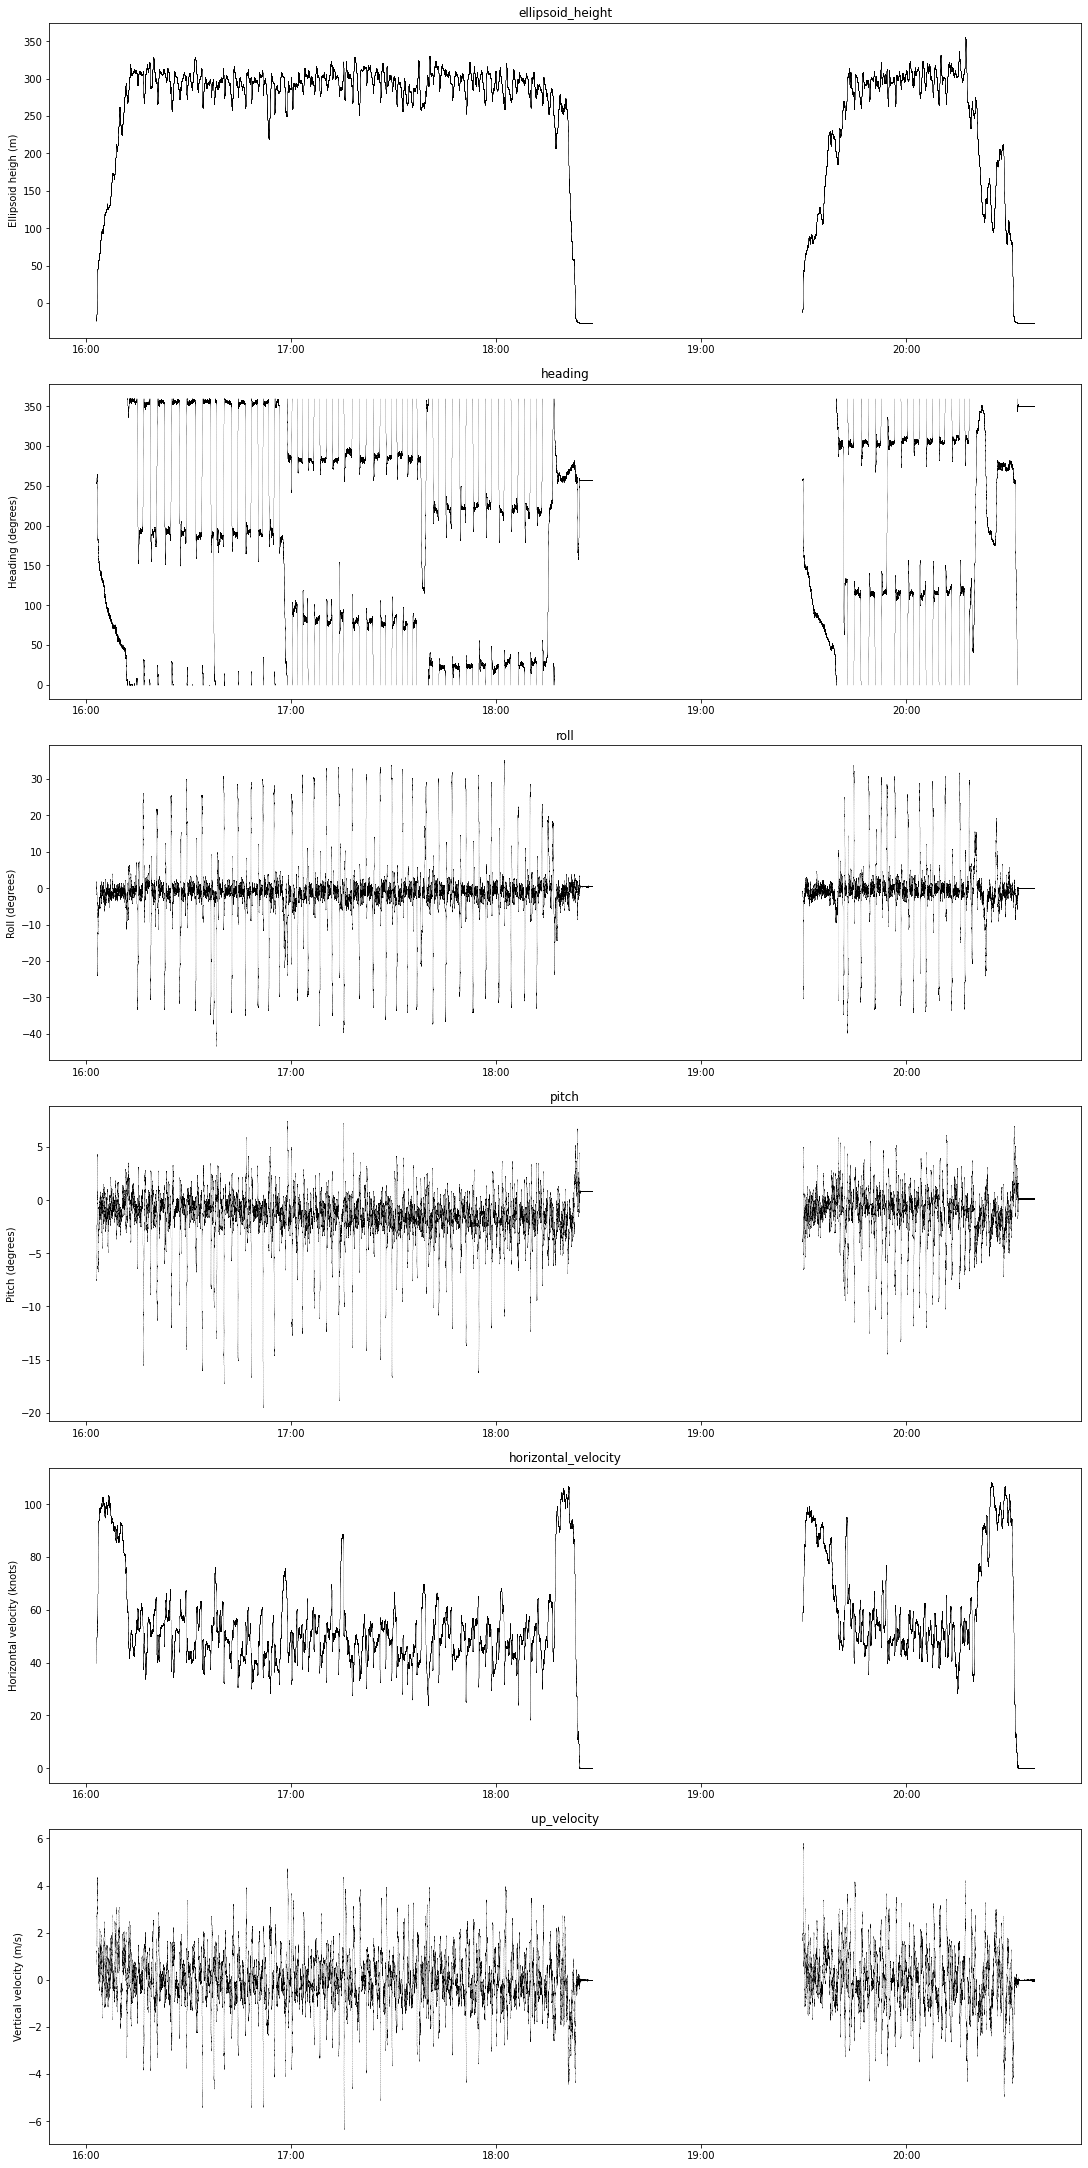

In [13]:
plt.rc('figure', figsize=(15, 5*len(idx)))

fig, axes = plt.subplots(len(idx), 1, 
                         #sharey=True,
                         #sharex = 'col'
                         constrained_layout=True
                        )
for i in range(len(idx)):
    label = cols[idx[i]]
    axes[i].scatter(time_formatted, flight[label], marker='.',s=.0001, c='k')
    axes[i].set_title(label)
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[i].set_ylabel(axis_labels[label])
    #axes[i].grid(linestyle='--', linewidth='1', color='#cccccc')
    #if label == 'heading':
    #    axes[i].set_yticks(np.arange(0, 361, 45))

### Zoom into a segment

Set the lower and upper bound of the time segment. For the temporal extent of each flight line, check [this file](../data/metadata/sp19-pw-lines.csv). 

In [14]:
t_min = timeutil.gpstime_to_datetime(576830.909467)
t_max = timeutil.gpstime_to_datetime(576853.315498)

buffer = timedelta(0, 3)

mask = (time_formatted > (t_min - buffer)) & (time_formatted < (t_max + buffer))

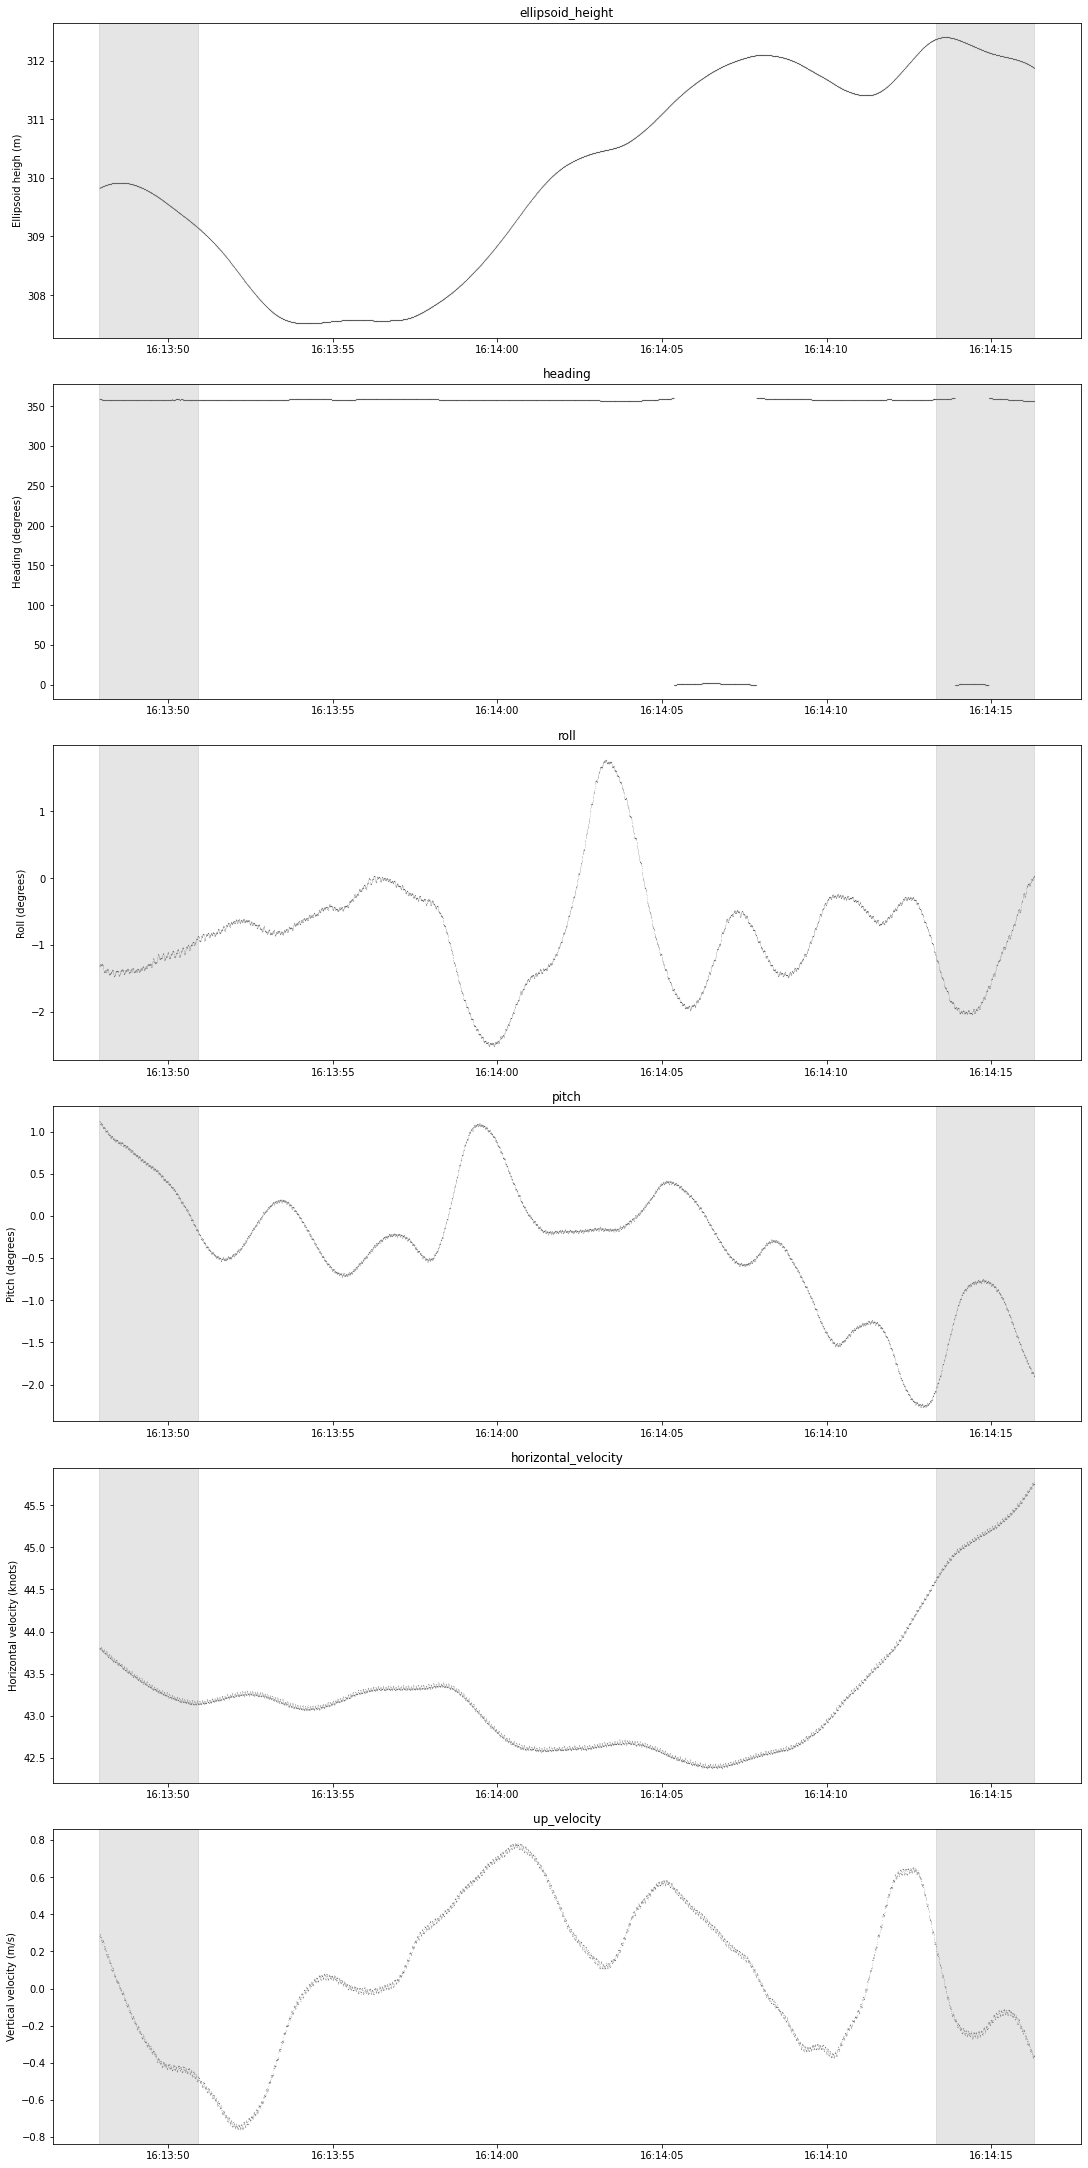

In [15]:
plt.rc('figure', figsize=(15, 5*len(idx)))

fig, axes = plt.subplots(len(idx), 1, 
                         #sharey=True,
                         #sharex = 'col'
                         constrained_layout=True
                        )
for i in range(len(idx)):
    label = cols[idx[i]]
    axes[i].scatter(time_formatted[mask], flight[label][mask], marker='.',s=.01, c='k')
    axes[i].set_title(label)
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axes[i].set_ylabel(axis_labels[label])
    
    axes[i].axvspan(t_min - buffer, t_min, alpha=0.2, color='gray')
    axes[i].axvspan(t_max, t_max + buffer, alpha=0.2, color='gray')